# Brain Tumor Detection and Localization
Vuyyuru Mohith Reddy - 190C2020021 <br>
Sunkara Sai Ram - 190C2030061 <br>
Kandagatla Sricharan - 190C2030089

## Import Libraries

In [53]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Pre-processing
### Data Preparation

In [54]:
Size = (256, 256)
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
train_files = [file.replace('_mask', '') for file in mask_files]

def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'

df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "label":[label(x) for x in mask_files]})

df.to_csv('brain_data.csv')

In [55]:
df = pd.read_csv('brain_data.csv')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3929 non-null   int64 
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   label       3929 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 122.9+ KB


In [57]:
df.head(5)

,Unnamed: 0,image_path,mask_path,label
0,0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1


In [58]:
df_train = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df_train.shape

(3929, 3)

In [59]:
df['label'].value_counts()

0    2556
1    1373
Name: label, dtype: int64

# Visualization

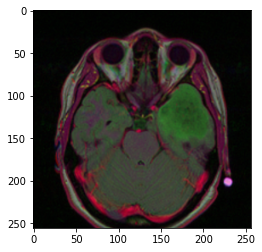

In [60]:
image = cv2.imread(df.image_path[121])
plt.imshow(image)

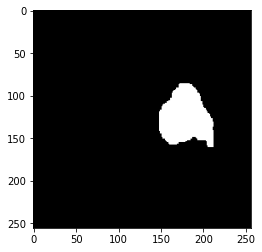

In [61]:
image1 = cv2.imread(df.mask_path[121])
plt.imshow(image1)

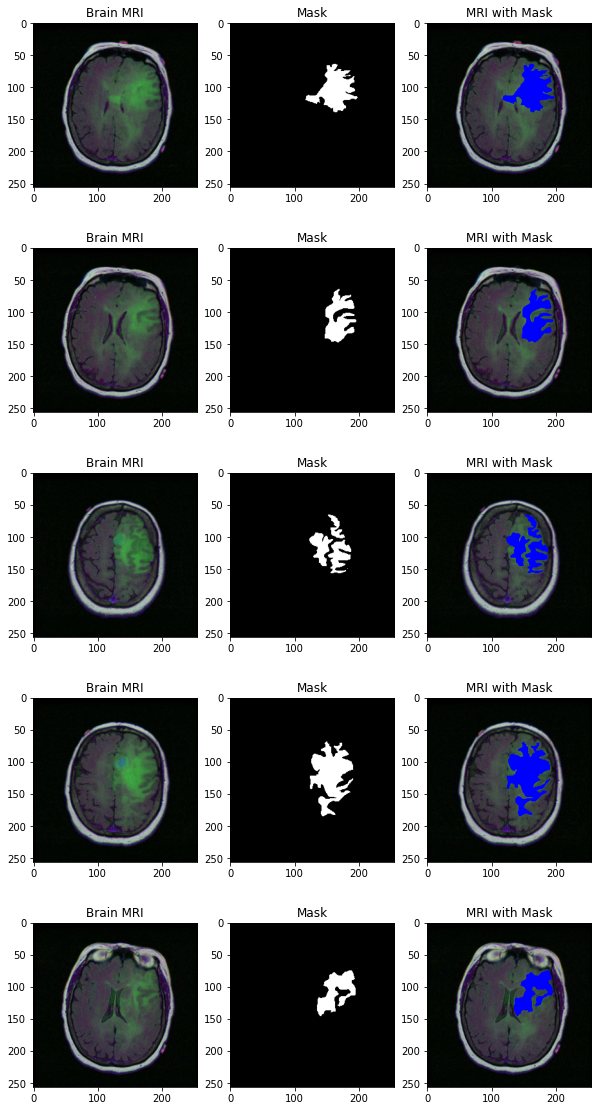

In [62]:
from skimage import io
count = 0
fig, axs = plt.subplots(5, 3, figsize = (10, 20))
for i in range(len(df)):
    if df['label'][i] ==1 and count <5:
        img = io.imread(df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')

        img[mask == 255] = (0, 0, 255)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

plt.show()

In [63]:
df_train['label'] = df_train['label'].apply(lambda x: str(x))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   label       3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


# Splitting the data into Train and Test Set

In [64]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_train, test_size = 0.15, random_state = 42)

# Create an image generator

In [65]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='label',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='label',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='label',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [66]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

# Building ResNet50 Model

In [67]:
# Get the ResNet50 base model (Transfer Learning)
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [68]:
# freeze the model weights
for layer in basemodel.layers:
    layers.trainable = False

In [69]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

ResNet50_model = Model(inputs = basemodel.input, outputs = headmodel)
ResNet50_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [70]:
from tensorflow.keras.optimizers import Adam
epochs = 15
learning_rate = 1e-4

decay_rate = learning_rate / epochs
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [71]:
ResNet50_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics= ["accuracy"])

In [72]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=2, mode='max',
    baseline=None, restore_best_weights=True)

# Train the ResNet50

In [73]:
ResNet50_history = ResNet50_model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 15, validation_data= valid_generator, validation_steps= valid_generator.n // 16,callbacks=[callback])

Epoch 1/15
177/177 [==============================] - 31s 143ms/step - loss: 0.4366 - accuracy: 0.7804 - val_loss: 4.6848 - val_accuracy: 0.6250
Epoch 2/15
177/177 [==============================] - 24s 136ms/step - loss: 0.2094 - accuracy: 0.9267 - val_loss: 2.9463 - val_accuracy: 0.6230
Epoch 3/15
177/177 [==============================] - 24s 137ms/step - loss: 0.1386 - accuracy: 0.9543 - val_loss: 5.4389 - val_accuracy: 0.6250
Epoch 4/15
177/177 [==============================] - 24s 136ms/step - loss: 0.1229 - accuracy: 0.9600 - val_loss: 1.2365 - val_accuracy: 0.6290
Epoch 5/15
177/177 [==============================] - 24s 136ms/step - loss: 0.0758 - accuracy: 0.9795 - val_loss: 0.7534 - val_accuracy: 0.7762
Epoch 6/15
177/177 [==============================] - 24s 137ms/step - loss: 0.0467 - accuracy: 0.9844 - val_loss: 0.2817 - val_accuracy: 0.9274
Epoch 7/15
177/177 [==============================] - 24s 137ms/step - loss: 0.0317 - accuracy: 0.9915 - val_loss: 0.1510 - val_ac

### Display the Accuracy and Loss Plot

In [74]:
ResNet50_history.history

{'loss': [0.4366385042667389,
  0.20941400527954102,
  0.13859589397907257,
  0.12294407188892365,
  0.07578817009925842,
  0.04673726484179497,
  0.031712327152490616,
  0.03229207172989845,
  0.017158357426524162,
  0.04559491202235222,
  0.033613257110118866,
  0.05364786460995674,
  0.08580058068037033,
  0.027945350855588913,
  0.018213070929050446],
 'accuracy': [0.7803754806518555,
  0.9266737699508667,
  0.9543039202690125,
  0.9599716663360596,
  0.9794544577598572,
  0.984413743019104,
  0.9914984107017517,
  0.9918526411056519,
  0.9943322539329529,
  0.9847679734230042,
  0.9900814890861511,
  0.9907899498939514,
  0.9759121537208557,
  0.9932695627212524,
  0.9943322539329529],
 'val_loss': [4.684804916381836,
  2.9462568759918213,
  5.438909530639648,
  1.2365450859069824,
  0.7533774971961975,
  0.28166407346725464,
  0.15099312365055084,
  0.09859157353639603,
  0.18005722761154175,
  0.2066693753004074,
  0.1397525668144226,
  0.21495258808135986,
  0.16574232280254364

In [75]:
print("ResNet50 training loss: ", round(min(ResNet50_history.history['loss']),3))
print("ResNet50 Val loss: ", round(min(ResNet50_history.history['val_loss']),3))
print("ResNet50 accuracy:", round(max(ResNet50_history.history['accuracy']),5)*100,"%")
print("ResNet50 Val accuracy:", round(max(ResNet50_history.history['val_accuracy']),4)*100,"%")

ResNet50 training loss:  0.017
ResNet50 Val loss:  0.099
ResNet50 accuracy: 99.433 %
ResNet50 Val accuracy: 96.98 %


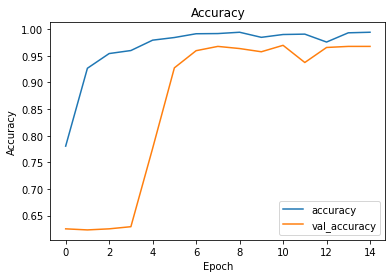

In [76]:
plt.plot(ResNet50_history.history['accuracy'], label='accuracy')
plt.plot(ResNet50_history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

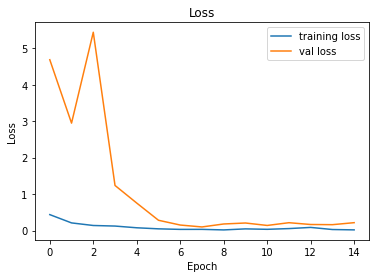

In [77]:
plt.plot(ResNet50_history.history['loss'], label='training loss')
plt.plot(ResNet50_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make prediction with ResNet50 model

In [78]:
test_predict = ResNet50_model.predict(test_generator, verbose =1)

ResNet50_predict = []
for i in test_predict:
    ResNet50_predict.append(str(np.argmax(i)))
ResNet50_predict = np.asarray(ResNet50_predict)

37/37 [==============================] - 3s 54ms/step


In [79]:
from sklearn.metrics import accuracy_score

ResNet50_accuracy = accuracy_score(np.array(list(map(str,test_generator.labels))), ResNet50_predict)
ResNet50_accuracy

0.9440677966101695

In [80]:
from sklearn.metrics import classification_report
report = classification_report(np.array(list(map(str,test_generator.labels))), ResNet50_predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       383
           1       0.98      0.86      0.91       207

   micro avg       0.94      0.94      0.94       590
   macro avg       0.96      0.92      0.94       590
weighted avg       0.95      0.94      0.94       590



# Building Inception Model

In [81]:
inception_basemodel = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
for layer in inception_basemodel.layers:
    layers.trainable = False

In [82]:
inception_headmodel = inception_basemodel.output
inception_headmodel = AveragePooling2D(pool_size = (4,4))(inception_headmodel)
inception_headmodel = Flatten(name= 'flatten')(inception_headmodel)
inception_headmodel = Dense(256, activation = "relu")(inception_headmodel)
inception_headmodel = Dropout(0.3)(inception_headmodel)
inception_headmodel = Dense(256, activation = "relu")(inception_headmodel)
inception_headmodel = Dropout(0.3)(inception_headmodel)
inception_headmodel = Dense(256, activation = "relu")(inception_headmodel)
inception_headmodel = Dropout(0.3)(inception_headmodel)
inception_headmodel = Dense(2, activation = 'softmax')(inception_headmodel)

inception_model = Model(inputs = inception_basemodel.input, outputs = inception_headmodel)
inception_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 127, 127, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 127, 127, 32) 96          conv2d_132[0][0]                 
__________________________________________________________________________________________________
activation_130 (Activation)     (None, 127, 127, 32) 0           batch_normalization_112[0][0]    
____________________________________________________________________________________________

In [83]:
inception_model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics= ["accuracy"])

# Train the Inception Model

In [84]:
inception_history = inception_model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 15, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[callback])

Epoch 1/15
177/177 [==============================] - 29s 127ms/step - loss: 0.5064 - accuracy: 0.7396 - val_loss: 0.3013 - val_accuracy: 0.8488
Epoch 2/15
177/177 [==============================] - 21s 119ms/step - loss: 0.2600 - accuracy: 0.9086 - val_loss: 0.1530 - val_accuracy: 0.9355
Epoch 3/15
177/177 [==============================] - 21s 120ms/step - loss: 0.1727 - accuracy: 0.9405 - val_loss: 0.1332 - val_accuracy: 0.9435
Epoch 4/15
177/177 [==============================] - 21s 119ms/step - loss: 0.0989 - accuracy: 0.9685 - val_loss: 0.1570 - val_accuracy: 0.9415
Epoch 5/15
177/177 [==============================] - 21s 119ms/step - loss: 0.0689 - accuracy: 0.9791 - val_loss: 0.0803 - val_accuracy: 0.9698
Epoch 6/15
177/177 [==============================] - 22s 123ms/step - loss: 0.0426 - accuracy: 0.9872 - val_loss: 0.1051 - val_accuracy: 0.9738
Epoch 7/15
177/177 [==============================] - 21s 120ms/step - loss: 0.0449 - accuracy: 0.9844 - val_loss: 0.0976 - val_ac

### Display the Accuracy and Loss Plot

In [85]:
inception_history.history

{'loss': [0.5064477324485779,
  0.25996360182762146,
  0.1726842075586319,
  0.09887784719467163,
  0.06888918578624725,
  0.04264863207936287,
  0.04491395503282547,
  0.04469811171293259,
  0.03201449289917946,
  0.029988430440425873,
  0.016658466309309006,
  0.01187804527580738,
  0.027638571336865425],
 'accuracy': [0.7396386861801147,
  0.9086078405380249,
  0.9404888153076172,
  0.9684732556343079,
  0.979100227355957,
  0.9872475862503052,
  0.984413743019104,
  0.9840595126152039,
  0.9865391254425049,
  0.9911441802978516,
  0.9950407147407532,
  0.9971661567687988,
  0.9950407147407532],
 'val_loss': [0.30134081840515137,
  0.15301543474197388,
  0.133215069770813,
  0.1570490300655365,
  0.08032950758934021,
  0.10511020570993423,
  0.09761754423379898,
  0.07551226764917374,
  0.09649758040904999,
  0.15323419868946075,
  0.14764440059661865,
  0.17873552441596985,
  0.10734639316797256],
 'val_accuracy': [0.8487903475761414,
  0.9354838728904724,
  0.9435483813285828,
  0

In [86]:
print("Inception training loss: ", round(min(inception_history.history['loss']),3))
print("Inception Val loss: ", round(min(inception_history.history['val_loss']),3))
print("Inception accuracy:", round(max(inception_history.history['accuracy']),5)*100,"%")
print("Inception Val accuracy:", round(max(inception_history.history['val_accuracy']),4)*100,"%")

Inception training loss:  0.012
Inception Val loss:  0.076
Inception accuracy: 99.717 %
Inception Val accuracy: 98.39 %


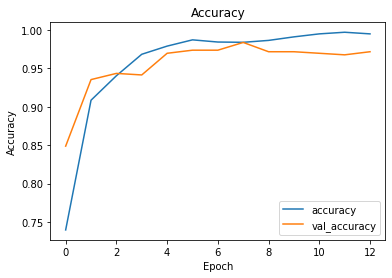

In [87]:
plt.plot(inception_history.history['accuracy'], label='accuracy')
plt.plot(inception_history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

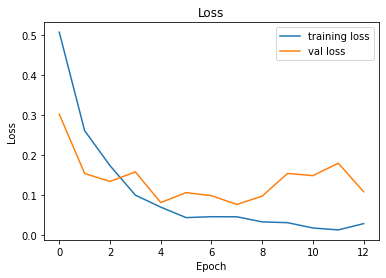

In [88]:
plt.plot(inception_history.history['loss'], label='training loss')
plt.plot(inception_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make Prediction with Inception model

In [89]:
test_predict = inception_model.predict(test_generator, verbose =1)

inception_predict = []
for i in test_predict:
    inception_predict.append(str(np.argmax(i)))
inception_predict = np.asarray(inception_predict)

37/37 [==============================] - 3s 41ms/step


In [90]:
from sklearn.metrics import accuracy_score

inception_accuracy = accuracy_score(np.array(list(map(str,test_generator.labels))), inception_predict)
inception_accuracy

0.9525423728813559

In [91]:
from sklearn.metrics import classification_report
report = classification_report(np.array(list(map(str,test_generator.labels))), inception_predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       383
           1       0.98      0.88      0.93       207

   micro avg       0.95      0.95      0.95       590
   macro avg       0.96      0.94      0.95       590
weighted avg       0.95      0.95      0.95       590



## Splitting the data into Train, validation and Test Set

In [92]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


## Data genertator & Data augmentation

In [93]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# Define loss function and metrics

In [94]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Building Unet Model

In [95]:
def unet_model(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [96]:
Unet_model = unet_model()
Unet_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_226 (Conv2D)             (None, 256, 256, 64) 1792        input_7[0][0]                    
__________________________________________________________________________________________________
activation_224 (Activation)     (None, 256, 256, 64) 0           conv2d_226[0][0]                 
__________________________________________________________________________________________________
conv2d_227 (Conv2D)             (None, 256, 256, 64) 36928       activation_224[0][0]             
____________________________________________________________________________________________

In [97]:
# epochs = 15
Batch_size = 16
# learning_rate = 1e-4

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, Batch_size, train_generator_args, target_size=(256, 256))
    
test_gener = train_generator(df_val, Batch_size, dict(), target_size=(256, 256))

# decay_rate = learning_rate / epochs
# optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

Unet_model = unet_model(input_size=(256, 256, 3))
Unet_model.compile(optimizer= optimizer, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

In [98]:
callbacks = [ModelCheckpoint('unet_brain_tumor.hdf5', verbose=1, save_best_only=True)]

# Train Unet Model

In [99]:
Unet_history = Unet_model.fit(train_gen,
                    steps_per_epoch=len(df_train) / Batch_size, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / Batch_size)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/15
177/176 [==============================] - ETA: 0s - loss: -0.2013 - binary_accuracy: 0.9642 - iou: 0.1181 - dice_coef: 0.2014Found 708 validated image filenames.
Found 708 validated image filenames.
176/176 [==============================] - 87s 485ms/step - loss: -0.2013 - binary_accuracy: 0.9642 - iou: 0.1181 - dice_coef: 0.2014 - val_loss: -0.1816 - val_binary_accuracy: 0.9723 - val_iou: 0.1008 - val_dice_coef: 0.1787

Epoch 00001: val_loss improved from inf to -0.18161, saving model to unet_brain_tumor.hdf5
Epoch 2/15
176/176 [==============================] - 86s 486ms/step - loss: -0.4253 - binary_accuracy: 0.9917 - iou: 0.2815 - dice_coef: 0.4254 - val_loss: -0.3573 - val_binary_accuracy: 0.9872 - val_iou: 0.2200 - val_dice_coef: 0.3517

Epoch 00002: val_loss improved from -0.18161 to -0.35731, saving model to unet_brain_tumor.hdf5
Epoch 3/15
176/176 [==============================] - 85s 480

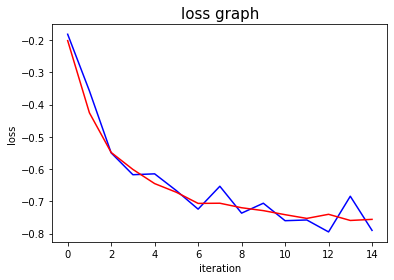

In [100]:
k = Unet_history.history

list_traindice = k['dice_coef']
list_testdice = k['val_dice_coef']

list_trainjaccard = k['iou']
list_testjaccard = k['val_iou']

list_trainloss = k['loss']
list_testloss = k['val_loss']

plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.show()

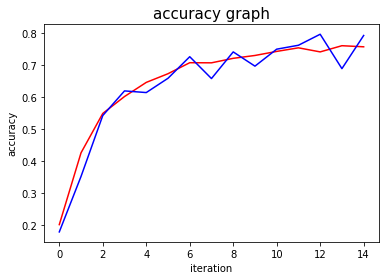

In [101]:
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [102]:
from tensorflow.keras.models import Model, load_model, save_model
model_unet = load_model('unet_brain_tumor.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [103]:
test_gen = train_generator(df_test, Batch_size, dict(), target_size=(256, 256))
results = model_unet.evaluate(test_gen, steps=len(df_test) / Batch_size)

print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
24/24 [==============================] - 3s 121ms/step - loss: -0.7441 - binary_accuracy: 0.9958 - iou: 0.6039 - dice_coef: 0.7453
Test lost:  -0.744124174118042
Test IOU:  0.995818555355072
Test Dice Coefficent:  0.6038951277732849


# Predicting the Mask and Localization

In [104]:
def apply_mask(pred,img):   
    for i in range(256):
        for j in range(256):
            if(pred[0][i][j][0]>0.5):
                img[0][i][j][0]=0
                img[0][i][j][1]=0
                img[0][i][j][2]=255
    return img

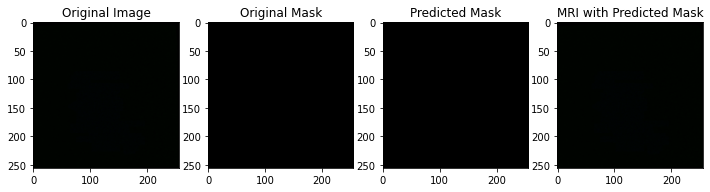

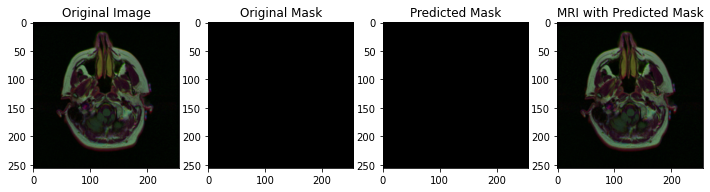

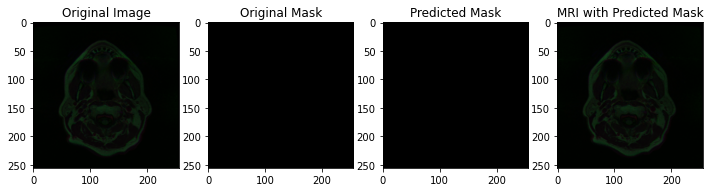

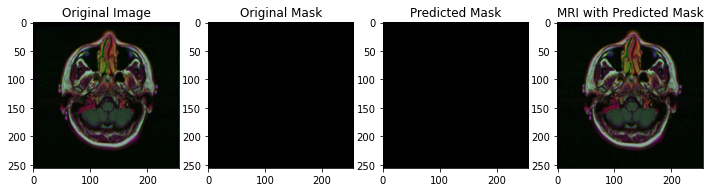

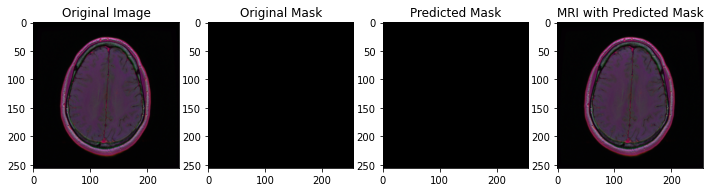

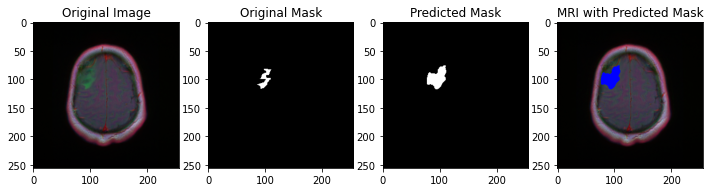

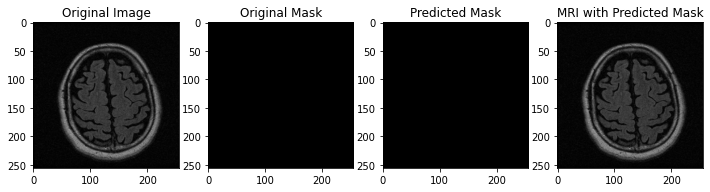

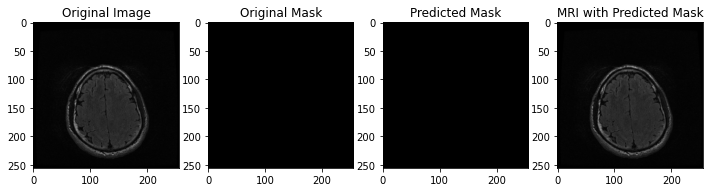

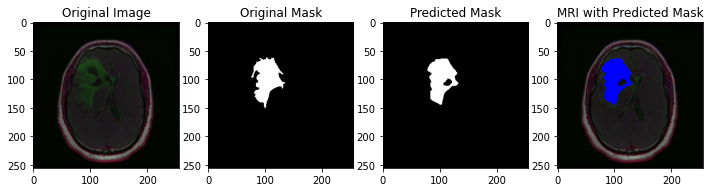

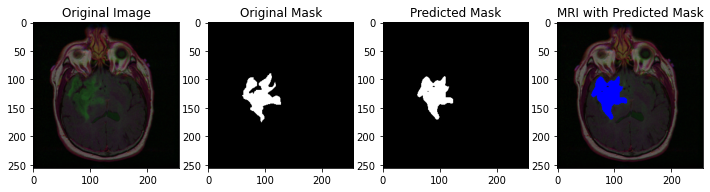

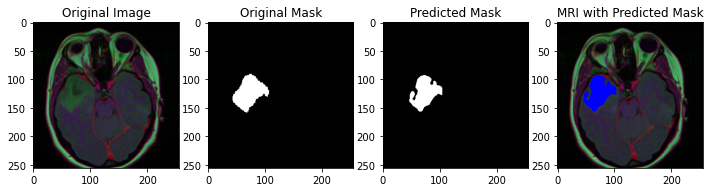

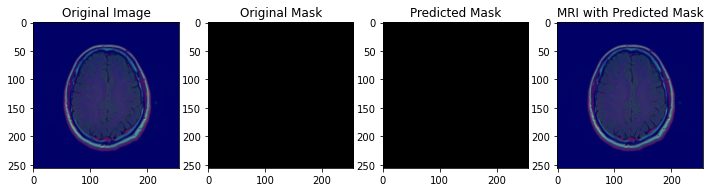

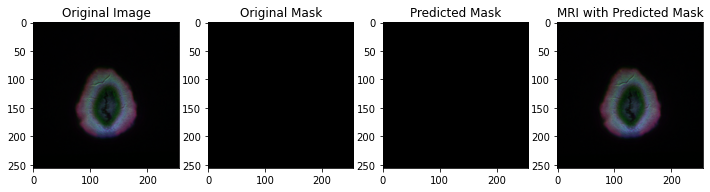

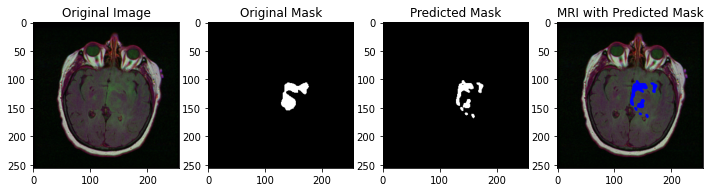

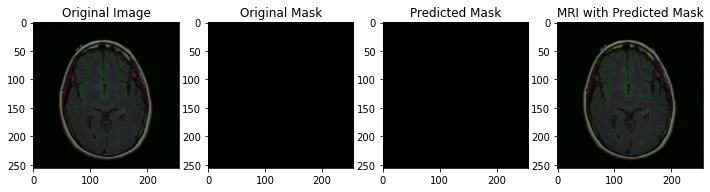

In [105]:
for i in range(15):
    index=np.random.randint(1,len(df_test.index))
#     index = i 
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_unet.predict(img)
#     pred = cv2.cvtColor(pred, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    
    plt.subplot(1,4,3)
#     plt.imshow(np.squeeze(pred)>0.5)
    plt.imshow(pred[0]>0.5,cmap='gray')
    plt.title('Predicted Mask')
    
    plt.subplot(1,4,4)
    plt.imshow(apply_mask(pred,img)[0])    
    plt.title('MRI with Predicted Mask')
    
    plt.show()